# Purposes of this document

the BMI3D implements clda in the form of learner and updater with
1. learner collect training samples that are paired from collected features and estiamted intentions. 
2. the updater is then used to update the decoder specifically Kalman filter's observation matrix. 

in this experiment, we confirm our understanding that
with different batch lengths, our updater does do harm to the  observation matrix. 

the main variables in this loop is 
1. learner's batch size
2. and the updater's rho which controls the amount of mixing between old and new decoder parameters. 



we are gonna set up with three exps with identical trial sequences. 
1. 10 sample lengths
2. 100 sample lengths 
3. 1000 sample lengths. 

in the end, 
we will demonstrate the mismatch through
1. the rewarded trials and the reward trial rate. 
2. qualitative comparisions of trajectories. 
3. the tuning directions of C. and the tracking performance using correlation coefficients

# comments

24 out of 24 
need measure performance as a function time. 
how many samples per trial?
run simulations longer.
how many updates are happening? the rates are the same withtin the tests, but run at different periods of time. 



In [1]:
import numpy as np


RHO = 0.5
batch_sizes = [10, 100, 1000]
exp_conds = [f'batch lenght:{b}' for b in batch_sizes]
exp_conds



UPDATER_BATCH_TIME = 1
UPDATER_HALF_LIFE = np.log(RHO)  * UPDATER_BATCH_TIME / np.log(0.5)

print(f'the updater half_life is {UPDATER_HALF_LIFE}')

the updater half_life is 1.0


In [2]:
NUM_EXP = len(exp_conds) # how many experiments we are running. 
#generate task params
N_TARGETS = 8
N_TRIALS = 24

# setting up the simulation components

this section largely copyied and pasted from   
bmi3d-sijia(branch)-bulti_in_experiemnts
https://github.com/sijia66/brain-python-interface/blob/master/built_in_tasks/sim_task_KF.py

In [3]:
# import libraries
# make sure these directories are in the python path., 
from bmimultitasks import SimBMIControlMulti, SimBMICosEncKFDec, BMIControlMultiNoWindow
from features import SaveHDF
from features.simulation_features import get_enc_setup, SimKFDecoderRandom, SimCosineTunedEnc,SimIntentionLQRController, SimClockTick
from features.simulation_features import SimHDF, SimTime

from riglib import experiment

from riglib.stereo_opengl.window import FakeWindow
from riglib.bmi import train

from weights import replace_kalman_filter
import weights

import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import itertools #for identical sequences


/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/blackrock/cerelink.py:13: UserWarning: Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system
  warnings.warn("Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system")


##  set up trial seq

In [4]:
seq = SimBMIControlMulti.sim_target_seq_generator_multi(
N_TARGETS, N_TRIALS)

#create a second version of the tasks
seqs = itertools.tee(seq, NUM_EXP)

##  simulation encoder decoder setup

In [5]:
#clda on random 
DECODER_MODE = 'trained' # in this case we load simulation_features.SimKFDecoderRandom
ENCODER_TYPE = 'cosine_tuned_encoder'
LEARNER_TYPE = 'feedback' # to dumb or not dumb it is a question 'feedback'
UPDATER_TYPE = 'smooth_batch' #none or "smooth_batch"


SAVE_HDF = False
SAVE_SIM_HDF = True #this makes the task data available as exp.task_data_hist
DEBUG_FEATURE = False

#neuron set up : 'std (20 neurons)' or 'toy (4 neurons)' 
N_NEURONS, N_STATES, sim_C = get_enc_setup(sim_mode = 'toy')

features.simulation_features: get_enc_setup has a tuning_level of 1 



## from the setup options, set up experiment

In [6]:
# set up assist level
assist_level = (0, 0)

#base_class = SimBMIControlMulti
base_class = BMIControlMultiNoWindow
feats = []

#set up intention feedbackcontroller
#this ideally set before the encoder
feats.append(SimIntentionLQRController)

#set up the encoder
if ENCODER_TYPE == 'cosine_tuned_encoder' :
    feats.append(SimCosineTunedEnc)
    print(f'{__name__}: selected SimCosineTunedEnc\n')
    
    
   #take care the decoder setup
if DECODER_MODE == 'random':
    feats.append(SimKFDecoderRandom)
    print(f'{__name__}: set base class ')
    print(f'{__name__}: selected SimKFDecoderRandom \n')
else: #defaul to a cosEnc and a pre-traind KF DEC
    from features.simulation_features import SimKFDecoderSup
    feats.append(SimKFDecoderSup)
    print(f'{__name__}: set decoder to SimKFDecoderSup\n')
    
    
#you know what? 
#learner only collects firing rates labeled with estimated estimates
#we would also need to use the labeled data
#now, we can set up a dumb/or not-dumb learner
if LEARNER_TYPE == 'feedback':
    from features.simulation_features import SimFeedbackLearner
    feats.append(SimFeedbackLearner)
else:
    from features.simulation_features import SimDumbLearner
    feats.append(SimDumbLearner)




#to update the decoder.
if UPDATER_TYPE == 'smooth_batch':
    from features.simulation_features import SimSmoothBatch
    feats.append(SimSmoothBatch)
else: #defaut to none 
    print(f'{__name__}: need to specify an updater')
    
if DEBUG_FEATURE: 
    from features.simulation_features import DebugFeature
    feats.append(DebugFeature)
    
if SAVE_HDF: feats.append(SaveHDF)
if SAVE_SIM_HDF: feats.append(SimHDF)
    
    
#pass the real time limit on clock
feats.append(SimClockTick)
feats.append(SimTime)


#save everthing in a kw
kwargs = dict()
kwargs['sim_C'] = sim_C

__main__: selected SimCosineTunedEnc

__main__: set decoder to SimKFDecoderSup



## seed the exp

In [7]:
np.random.seed(0)

## make our experiment class

In [8]:
#spawn the task
Exp = experiment.make(base_class, feats=feats)


metaclass constructor
(<class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEnc'>, <class 'features.simulation_features.SimKFDecoderSup'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>, <class 'bmimultitasks.BMIControlMultiNoWindow'>)
[<class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEnc'>, <class 'features.simulation_features.SimKFDecoderSup'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>]


# creat experiments with different C batch lengths

## create exps

In [9]:
exps = [Exp(s, **kwargs) for s in seqs]


features.simulation_features.SimIntentionLQRController: LQRController used 


 features.simulation_features.SimFeedbackLearner: start to create a sim leaner with a batchsize of 16
features.simulation_features.SimSmoothBatch: rho in this simulation is  0.9885140203528962

finished executing Experiment.__init__

features.simulation_features.SimIntentionLQRController: LQRController used 


 features.simulation_features.SimFeedbackLearner: start to create a sim leaner with a batchsize of 16
features.simulation_features.SimSmoothBatch: rho in this simulation is  0.9885140203528962

finished executing Experiment.__init__

features.simulation_features.SimIntentionLQRController: LQRController used 


 features.simulation_features.SimFeedbackLearner: start to create a sim leaner with a batchsize of 16
features.simulation_features.SimSmoothBatch: rho in this simulation is  0.9885140203528962

finished executing Experiment.__init__


In [10]:
for e in exps: e.init()


SimCosineTunedEnc SSM: State space: ['hand_px', 'hand_py', 'hand_pz', 'hand_vx', 'hand_vy', 'hand_vz', 'offset'] 

neural encoder init function  <BMIControlMultiNoWindow(Thread-4, initial)>
features.simulation_features: added tracking of K matrix
Creating simulation decoder..
SimKFDecoderSup:loaded self.encoder
<riglib.bmi.sim_neurons.GenericCosEnc object at 0x7f8cb1861ca0> <class 'riglib.bmi.sim_neurons.GenericCosEnc'>
SimKFDecoderSup:loaded self.ssm
<riglib.bmi.sim_neurons.GenericCosEnc object at 0x7f8cb1861ca0> <class 'riglib.bmi.sim_neurons.GenericCosEnc'>
SimKFDecoderSup: units:  4
 SimKFDecoderSup: zscore decoder ? :  False
{}
end of kwargs
('zscore value: ', False, <class 'bool'>)
no init_zscore
Reset states for learner: 
[]
Done states for learner: 
[]

features.simulation_features.SimFeedbackLearner: flip the self.learn_flag to true
features.simulation_features.SimFeedbackLearner: succussfully created a feedback controller learner


SimSmoothBatch: created an updater with a b

## control for the same rho

In [11]:
for e in exps:
    e.batch_time = UPDATER_BATCH_TIME
    e.half_life = UPDATER_HALF_LIFE
    e.create_updater()


SimSmoothBatch: created an updater with a batch time of 1 and a half_life of 1.0 


SimSmoothBatch: created an updater with a batch time of 1 and a half_life of 1.0 


SimSmoothBatch: created an updater with a batch time of 1 and a half_life of 1.0 



## create the three batch sizes

In [12]:
#before
for i,e in enumerate(exps):
    print(e.batch_size)

16
16
16


In [13]:
#before
for i,e in enumerate(exps):
    e.batch_size = batch_sizes
    e.create_learner() #let the batch length propagte to the program

Reset states for learner: 
[]
Done states for learner: 
[]

features.simulation_features.SimFeedbackLearner: flip the self.learn_flag to true
features.simulation_features.SimFeedbackLearner: succussfully created a feedback controller learner

Reset states for learner: 
[]
Done states for learner: 
[]

features.simulation_features.SimFeedbackLearner: flip the self.learn_flag to true
features.simulation_features.SimFeedbackLearner: succussfully created a feedback controller learner

Reset states for learner: 
[]
Done states for learner: 
[]

features.simulation_features.SimFeedbackLearner: flip the self.learn_flag to true
features.simulation_features.SimFeedbackLearner: succussfully created a feedback controller learner



# assemble into a complete loop

In [14]:
#make this into a loop

def run_exp_loop(exp):
        # riglib.experiment: line 597 - 601
    #exp.next_trial = next(exp.gen)
    # -+exp._parse_next_trial()np.arraynp.array


    # we need to set the initial state
    # per fsm.run:  line 138


    # Initialize the FSM before the loop
    exp.set_state(exp.state)


    while exp.state is not None:

        # exp.fsm_tick()

        ### Execute commands#####
        exp.exec_state_specific_actions(exp.state)

        ###run the bmi loop #####
        # _cycle

        # bmi feature extraction, eh
        #riglib.bmi: 1202
        feature_data = exp.get_features()

        # Determine the target_state and save to file
        current_assist_level = exp.get_current_assist_level()
        '''
            if np.any(current_assist_level > 0) or exp.learn_flag:
            target_state = exp.get_target_BMI_state(exp.decoder.states)
        else:
            target_state = np.ones(
                [exp.decoder.n_states, exp.decoder.n_subbins]) * np.nan

        '''
        target_state = exp.get_target_BMI_state(exp.decoder.states)


        # decode the new features
        # riglib.bmi.bmiloop: line 1245
        neural_features = feature_data[exp.extractor.feature_type]

        # call decoder.
        #tmp = exp.call_decoder(neural_features, target_state, **kwargs)
        neural_obs = neural_features
        learn_flag = exp.learn_flag
        task_state = exp.state

        n_units, n_obs = neural_obs.shape
        # If the target is specified as a 1D position, tile to match
        # the number of dimensions as the neural features
        if np.ndim(target_state) == 1 or (target_state.shape[1] == 1 and n_obs > 1):
            target_state = np.tile(target_state, [1, n_obs])

        decoded_states = np.zeros([exp.bmi_system.decoder.n_states, n_obs])
        update_flag = False

        for k in range(n_obs):
            neural_obs_k = neural_obs[:, k].reshape(-1, 1)
            target_state_k = target_state[:, k]

            # NOTE: the conditional below is *only* for compatibility with older Carmena
            # lab data collected using a different MATLAB-based system. In all python cases,
            # the task_state should never contain NaN values.
            if np.any(np.isnan(target_state_k)):
                task_state = 'no_target'

            #################################
            # Decode the current observation
            #################################
            decodable_obs, decode = exp.bmi_system.feature_accumulator(
                neural_obs_k)
            if decode:  # if a new decodable observation is available from the feature accumulator
                prev_state = exp.bmi_system.decoder.get_state()

                exp.bmi_system.decoder(decodable_obs, **kwargs)
                # Determine whether the current state or previous state should be given to the learner
                if exp.bmi_system.learner.input_state_index == 0:
                    learner_state = exp.bmi_system.decoder.get_state()
                elif exp.bmi_system.learner.input_state_index == -1:
                    learner_state = prev_state
                else:
                    print(("Not implemented yet: %d" %
                           exp.bmi_system.learner.input_state_index))
                    learner_state = prev_state

                if learn_flag:
                    exp.bmi_system.learner(decodable_obs.copy(), learner_state, target_state_k, exp.bmi_system.decoder.get_state(
                    ), task_state, state_order=exp.bmi_system.decoder.ssm.state_order)

            decoded_states[:, k] = exp.bmi_system.decoder.get_state()

            ############################
            # Update decoder parameters
            ############################
            if exp.bmi_system.learner.is_ready():
                batch_data = exp.bmi_system.learner.get_batch()
                batch_data['decoder'] = exp.bmi_system.decoder
                kwargs.update(batch_data)
                exp.bmi_system.updater(**kwargs)
                exp.bmi_system.learner.disable()

            new_params = None  # by default, no new parameters are available
            if exp.bmi_system.has_updater:
                new_params = copy.deepcopy(exp.bmi_system.updater.get_result())

            # Update the decoder if new parameters are available
            if not (new_params is None):
                exp.bmi_system.decoder.update_params(
                    new_params, **exp.bmi_system.updater.update_kwargs)
                new_params['intended_kin'] = batch_data['intended_kin']
                new_params['spike_counts_batch'] = batch_data['spike_counts']

                exp.bmi_system.learner.enable()
                update_flag = True

                # Save new parameters to parameter history
                exp.bmi_system.param_hist.append(new_params)



        # saved as task data
        # return decoded_states, update_flag
        tmp = decoded_states
        exp.task_data['internal_decoder_state'] = tmp

        # reset the plant position
        # @riglib.bmi.BMILoop.move_plant  line:1254
        exp.plant.drive(exp.decoder)

        # check state transitions and run the FSM.
        current_state = exp.state

        # iterate over the possible events which could move the task out of the current state
        for event in exp.status[current_state]:
            # if the event has occurred
            if exp.test_state_transition_event(event):
                # execute commands to end the current state
                exp.end_state(current_state)

                # trigger the transition for the event
                exp.trigger_event(event)

                # stop searching for transition events (transition events must be
                # mutually exclusive for this FSM to function properly)
                break

        # sort out the loop params.
        # inc cycle count
        exp.cycle_count += 1

        # save target data as was done in manualControlTasks._cycle
        exp.task_data['target'] = exp.target_location.copy()
        exp.task_data['target_index'] = exp.target_index

        #done in bmi:_cycle after move_plant
        exp.task_data['loop_time'] = exp.iter_time()


        #fb_controller data
        exp.task_data['target_state'] = target_state

        #encoder data
        #input to this is actually extractor
        exp.task_data['ctrl_input'] = np.reshape(exp.extractor.sim_ctrl, (1,-1))

        #actually output
        exp.task_data['spike_counts'] = feature_data['spike_counts']


        #save the decoder_state
        #from BMILoop.move_plant
        exp.task_data['decoder_state'] = exp.decoder.get_state(shape=(-1,1))


        # as well as plant data.
        plant_data = exp.plant.get_data_to_save()
        for key in plant_data:
            exp.task_data[key] = plant_data[key]

        # clda data handled in the above call.

        # save to the list hisory of data.
        exp.task_data_hist.append(exp.task_data.copy())


    if exp.verbose:
        print("end of FSM.run, task state is", exp.state)
    
    


In [15]:
for i,e in enumerate(exps):
    run_exp_loop(e)
    print(f'Finished running  {exp_conds[i]}')

runseq
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters


/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/bmi/kfdecoder.py:372: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C = np.mat(np.linalg.lstsq(X.T, Y.T)[0].T)


KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothba

KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothbatch: calculating new SB parameters
KFSmoothba

# Preprocess the data for loading

In [16]:
for e in  exps: print(e.calc_state_occurrences('reward'))

24
24
24


# Walk through the analysis loop

In [17]:


print(exp_conds)

INDEX_RANDOM_DECODER = 0
INDEX_PRETRAINED = 1
INDEX_SAME_ENC = 2

['batch lenght:10', 'batch lenght:100', 'batch lenght:1000']


## declare defs and conventions

In [18]:
FRAME_RATE = 60
INT_WINDOW_TIME = 10 # s for looking at sample raw data

# some conventions as we go down the loop
X_VEL_STATE_IND = 3
Y_VEL_STATE_IND = 5
X_POS_STATE_IND = 0
Y_POS_STATE_IND = 2

state_indices = [X_POS_STATE_IND,
                 Y_POS_STATE_IND,
                 X_VEL_STATE_IND,
                 Y_VEL_STATE_IND]
state_names = ['x pos ', 'y pos', 'x vel', 'y vel']


INT_WIN_SAMPLES = INT_WINDOW_TIME * FRAME_RATE



## Quick look at the cursor trajectories

In [19]:
task_data_hist_np_all = [np.array(e.task_data_hist) for e in exps]
len(task_data_hist_np_all)

3

Text(0, 0.5, 'y position (cm)')

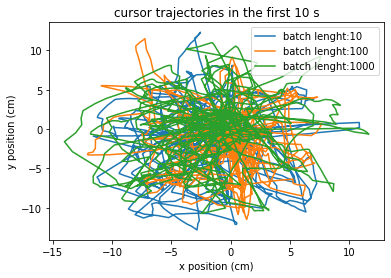

In [20]:
cursor_trajectories = [np.squeeze(task_data_hist_np['cursor']) for task_data_hist_np in task_data_hist_np_all]

for cursor_trajectory in cursor_trajectories:
    plt.plot(cursor_trajectory[:,0], cursor_trajectory[:,2])
    
# add cursor trajectories
plt.title(f'cursor trajectories in the first {INT_WINDOW_TIME} s')
plt.legend(exp_conds)
plt.xlabel('x position (cm)')
plt.ylabel('y position (cm)')

##  General trial based statistics

In [21]:
print('finished trials ')

for i,e in  enumerate(exps): 
    reward_num = e.calc_state_occurrences('reward')
    print(f'{exp_conds[i]}: {reward_num} out of {N_TRIALS}')

finished trials 
batch lenght:10: 24 out of 24
batch lenght:100: 24 out of 24
batch lenght:1000: 24 out of 24


## examine kf tracking

### examine the tuning curves

steady state tuning curves


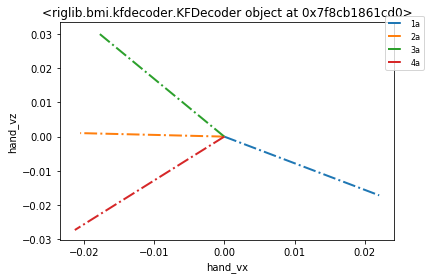

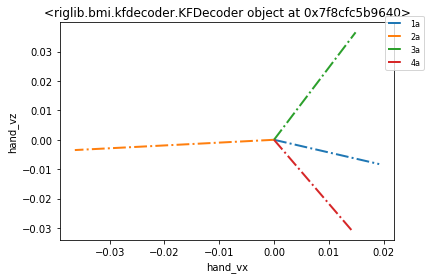

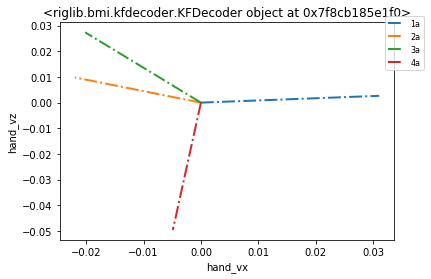

In [22]:
print('steady state tuning curves')

for i,e in enumerate(exps):
    e.decoder.plot_C()

### loading the data

In [23]:
# inputs to the encoder

decoder_states_all = [ np.squeeze(task_data_hist_np['decoder_state']) for task_data_hist_np in task_data_hist_np_all]
encoder_ctrl_input_all  = [ np.squeeze(task_data_hist_np['ctrl_input']) for task_data_hist_np in task_data_hist_np_all]


### tracking the velocity encoding

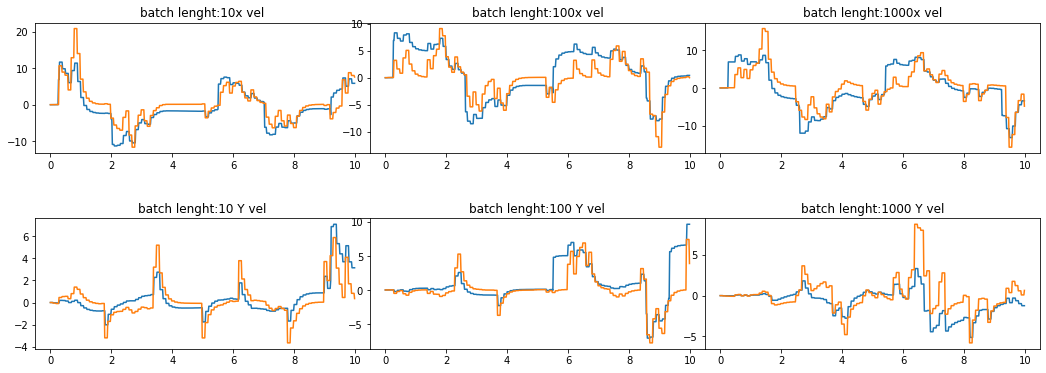

In [24]:
NUM_SUBPLOT_ROWS = 2
NUM_SUBPLOT_COLUMNS = NUM_EXP


fig, axes = plt.subplots(NUM_SUBPLOT_ROWS,NUM_EXP, figsize=(18, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

time_axis = np.arange(INT_WIN_SAMPLES)/FRAME_RATE 

for i,a in enumerate(axes[0]):
    
    a.plot(time_axis, encoder_ctrl_input_all[i][:INT_WIN_SAMPLES,X_VEL_STATE_IND])
    a.plot(time_axis, decoder_states_all[i][:INT_WIN_SAMPLES,X_VEL_STATE_IND])
    a.set_title(exp_conds[i] +  'x vel')
    
    


for i,a in enumerate(axes[1]):
    
    a.plot(time_axis, encoder_ctrl_input_all[i][:INT_WIN_SAMPLES,Y_VEL_STATE_IND])
    a.plot(time_axis, decoder_states_all[i][:INT_WIN_SAMPLES,Y_VEL_STATE_IND])
    a.set_title(exp_conds[i] +  ' Y vel')

In [25]:
N_VAR_1 = 0
N_VAR_2 = 1

corr_coefs = list()
N_STATES = 7

for i,ee in enumerate(exps):
    corr_coef = [np.corrcoef(encoder_ctrl_input_all[i][:INT_WIN_SAMPLES,state_i],
                            decoder_states_all[i][:INT_WIN_SAMPLES,state_i])[N_VAR_1,N_VAR_2]  for state_i in range(N_STATES)]
    corr_coefs.append(corr_coef)
    


/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/numpy/lib/function_base.py:2525: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Text(0, 0.5, 'Corr. coef.')

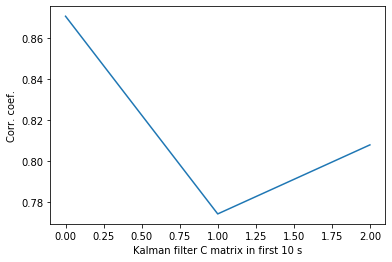

In [26]:
# look at only one tracking. 
corrcoef_x_vel_all  = [c[X_VEL_STATE_IND] for c in corr_coefs]


plt.plot(corrcoef_x_vel_all)
plt.xlabel(f'Kalman filter C matrix in first {INT_WINDOW_TIME} s')
plt.ylabel('Corr. coef.')

from the analyses above we see that the encoder-decoder mismatch does influence the kalman filter performance
from 

the random decoder failed to finish the tasks. 
the random decoder's decoder trajectorty
low tracking performance.

# additional analyses

## this system starts from feedback_controller

feedback controller generates ctrl input matrix   
from the difference between the target state and the and current state

from LQRcontroller

 ns = self.A * current_state + self.B * self.F * (target_state - current_state)

In [27]:
for e in exps: 
    print(e.fb_ctrl.A)
    print()

[[1.  0.  0.  0.1 0.  0.  0. ]
 [0.  1.  0.  0.  0.1 0.  0. ]
 [0.  0.  1.  0.  0.  0.1 0. ]
 [0.  0.  0.  0.8 0.  0.  0. ]
 [0.  0.  0.  0.  0.8 0.  0. ]
 [0.  0.  0.  0.  0.  0.8 0. ]
 [0.  0.  0.  0.  0.  0.  1. ]]

[[1.  0.  0.  0.1 0.  0.  0. ]
 [0.  1.  0.  0.  0.1 0.  0. ]
 [0.  0.  1.  0.  0.  0.1 0. ]
 [0.  0.  0.  0.8 0.  0.  0. ]
 [0.  0.  0.  0.  0.8 0.  0. ]
 [0.  0.  0.  0.  0.  0.8 0. ]
 [0.  0.  0.  0.  0.  0.  1. ]]

[[1.  0.  0.  0.1 0.  0.  0. ]
 [0.  1.  0.  0.  0.1 0.  0. ]
 [0.  0.  1.  0.  0.  0.1 0. ]
 [0.  0.  0.  0.8 0.  0.  0. ]
 [0.  0.  0.  0.  0.8 0.  0. ]
 [0.  0.  0.  0.  0.  0.8 0. ]
 [0.  0.  0.  0.  0.  0.  1. ]]



In [28]:
for e in exps: 
    print(e.fb_ctrl.B)
    print()

[[  0.   0.   0.]
 [  0.   0.   0.]
 [  0.   0.   0.]
 [100.   0.   0.]
 [  0. 100.   0.]
 [  0.   0. 100.]
 [  0.   0.   0.]]

[[  0.   0.   0.]
 [  0.   0.   0.]
 [  0.   0.   0.]
 [100.   0.   0.]
 [  0. 100.   0.]
 [  0.   0. 100.]
 [  0.   0.   0.]]

[[  0.   0.   0.]
 [  0.   0.   0.]
 [  0.   0.   0.]
 [100.   0.   0.]
 [  0. 100.   0.]
 [  0.   0. 100.]
 [  0.   0.   0.]]



this feedback_controller matrix is calculated using the infinite horizon Linear Quardratic Programming method
at the beginining 

again, from this equation  
Bu = B * F * (target_state - current_state)  
we get the control input

## and the encoder generates the control firing rates from the control Bu vector

from GenCosEnc line 130  
rates = np.dot(self.C, next_state)  
here, the Bu matrix is the next state  

the rates are then used to gen spike counts in the same decoder function 

In [29]:


for e in encoder_ctrl_input_all:
    print(e.shape)

(12155, 7)
(9455, 7)
(12550, 7)


Text(0.5, 1.0, 'Control vectors that go into the encoder')

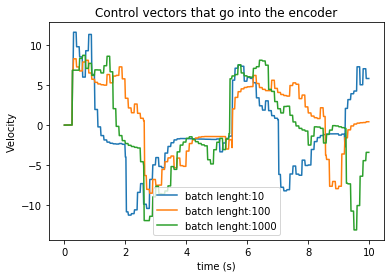

In [30]:


for encoder_ctrl_input in encoder_ctrl_input_all:
    time_axis = np.arange(INT_WIN_SAMPLES) / FRAME_RATE
    plt.plot(time_axis, encoder_ctrl_input[:INT_WIN_SAMPLES, X_VEL_STATE_IND]  )

plt.legend(exp_conds)
plt.xlabel('time (s)')
plt.ylabel('Velocity')
plt.title('Control vectors that go into the encoder')

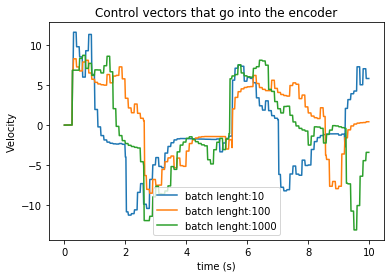

In [31]:
time_axis = np.arange(INT_WIN_SAMPLES) / FRAME_RATE

for encoder_ctrl_input in encoder_ctrl_input_all:
    plt.plot(time_axis, 
             encoder_ctrl_input[:INT_WIN_SAMPLES, (X_VEL_STATE_IND, )])
    
    
plt.xlabel('time (s)')
plt.ylabel('Velocity')
plt.title('Control vectors that go into the encoder')
plt.legend(exp_conds)

# compare decoder tracking with encoder

we started off with three configurations of the decoder matrix.
1. randomly assigned
2. pretrained on gaussian generated state-firing pairs, the states were not coupled
3. exactly the same as the decoder matrix

In [32]:
for e in exps:
    print(f'The tuning angles {exp_conds[i]}')
    print(weights.cal_tuning_angle(np.array(e.bmi_system.decoder.filt.C)))

The tuning angles batch lenght:1000
[-37.86734931  -2.86191    -59.38409607  52.04082145]
The tuning angles batch lenght:1000
[-23.28506147   5.49513869  67.82933492 -65.27482671]
The tuning angles batch lenght:1000
[  4.87615883 -24.09146435 -53.63642279  84.37051917]


yet, they all have the same A matrices


In [33]:
for i,e in enumerate(exps):
    print(f'the Kalman C matrix for {exp_conds[i]}')
    print(e.encoder.C)

the Kalman C matrix for batch lenght:10
[[ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.]]
the Kalman C matrix for batch lenght:100
[[ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.]]
the Kalman C matrix for batch lenght:1000
[[ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.]]


let's look at the firing rates 

In [34]:
firing_rates_all = [ np.squeeze(task_data_hist_np['spike_counts']) for task_data_hist_np in task_data_hist_np_all]

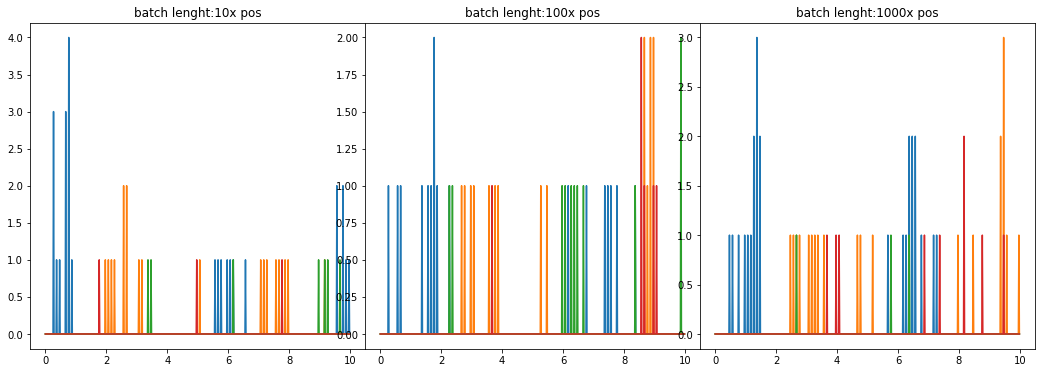

In [35]:
NUM_SUBPLOT_ROWS = 1
NUM_SUBPLOT_COLUMNS = NUM_EXP


fig, axes = plt.subplots(NUM_SUBPLOT_ROWS,NUM_EXP, figsize=(18, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)


for i,a in enumerate(axes):
    
    a.plot(time_axis, firing_rates_all[i][:INT_WIN_SAMPLES,:])
    a.set_title(exp_conds[i] +  'x pos')

they are all really sparse

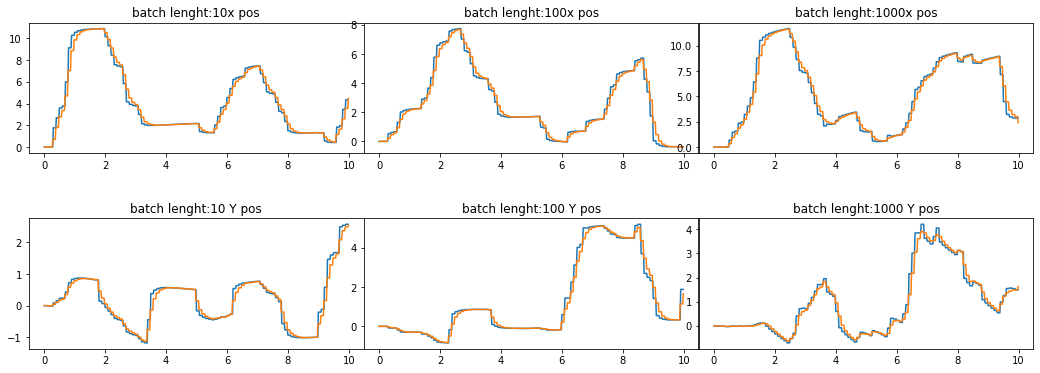

In [36]:
NUM_SUBPLOT_ROWS = 2
NUM_SUBPLOT_COLUMNS = NUM_EXP


fig, axes = plt.subplots(NUM_SUBPLOT_ROWS,NUM_EXP, figsize=(18, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

time_axis = np.arange(INT_WIN_SAMPLES)/FRAME_RATE 

for i,a in enumerate(axes[0]):
    
    a.plot(time_axis, encoder_ctrl_input_all[i][:INT_WIN_SAMPLES,X_POS_STATE_IND])
    a.plot(time_axis, decoder_states_all[i][:INT_WIN_SAMPLES,X_POS_STATE_IND])
    a.set_title(exp_conds[i] +  'x pos')
    
    


for i,a in enumerate(axes[1]):
    
    a.plot(time_axis, encoder_ctrl_input_all[i][:INT_WIN_SAMPLES,Y_POS_STATE_IND])
    a.plot(time_axis, decoder_states_all[i][:INT_WIN_SAMPLES,Y_POS_STATE_IND])
    a.set_title(exp_conds[i] +  ' Y pos')
    

this tracks really well 
I think because the Kalman filter does not run on the positions. 

this is very interesing 

# summarize the behaviour

In [37]:
def filter_state(state_log:list, state_to_match:str)->list:
    '''
    state_log: a list of tuples (state:string, start_time: float)
    state_to_watch
    
    returns a list of element type
    '''
    
    
    return list(filter(lambda k: k[0] == state_to_match, state_log) )

def calc_inter_wait_times(wait_log: list)-> list:
    """
    state_log: a list of tuples ("wait", start_time: float)
    return a list of tuples: ("wait", start_time: float, diff_time)
    """
    wait_log_with_diff = list()
    for i, wait_state in enumerate(wait_log):
        if i == len(wait_log)-1: #there is nothing to subtract, just put zero.
            wait_log_with_diff.append((wait_state[1],  0))
            
        else:
            finish_time = wait_log[i+1][1]
            wait_log_with_diff.append((wait_state[1],  finish_time - wait_state[1]))
    
    return np.array(wait_log_with_diff[:-1])
    
    

#wait_seq = filter_state(state_log, 'wait')
#wait_seq_diff = np.array(calc_inter_wait_times(wait_seq))
#len(wait_seq_diff)

# examine tracking by trial

In [38]:
#get the timings 
i = 0

corre_coef_exp = list()
for e_i,e in enumerate(exps):
    
    
    corr_coef_window = list()
    for trial_start_time, trial_length in wait_seq_diff:
        win_start_sample = int(trial_start_time * FRAME_RATE)
        win_finish_sample = int((trial_start_time + trial_length) * FRAME_RATE)

        window_range = range(win_start_sample,win_finish_sample)

        corr_coef = [np.corrcoef(encoder_ctrl_input_all[i][window_range,state_i],
                            decoder_states_all[i][window_range,state_i])[1,1]  for state_i in range(N_STATES)]

        corr_coef_window.append(corr_coef)
    
    corre_coef_exp.append(corr_coef_window)
    

    
corre_coef_exp = np.array(corre_coef_exp)
corre_coef_exp.shape

NameError: name 'wait_seq_diff' is not defined

In [ ]:
plt.plot(np.squeeze(corre_coef_exp[:,:,X_VEL_STATE_IND]).T)
